In [1]:
# EDA OBJECTIVE
# Finding features of customer profiles that have a tendancy to churn
# Dataset taken after Shavie's dataset clean at commit e9d186a20fbf4ebf48f40e0eef0ca02c751f7d29

# Method
# Find the most dominant customer profile that churned with all features
# Find all profiles like dominant churn in non-churn subset
# Highlight dominant features that lead to churn

# Findings
# With senior citizens excluded,
# The number of churns represents 23.6% of the whole dataset.
# Of those, a majority left after 1 month
# 0.2% more female churns than male
# 66.2% of customers that churned do not have partners
# 78.2% of customers that churned do not have dependents
# Month-to-Month contract type represents 87.2% of all churns, roughly 1'200 people
# 71.9% of the customers who churned used paperless billing
# 54.1% of customers that we on Electronic check payment method churned on high end 
#    \vs. 12.2% paying by automatic credit card payment on low end

# General observations
# Single females with no children on a monthly contract receiving paperless bills and paying via electronic check churned most.
# Their service profile is primarily phone service and fiber optic internet.
# They about 3/4th had no online security, tech support, device protection or online backup services.



# Corrections
# Defer rows where seniors == yes
# Renamed labels for representation accuracy

# To do
# Tenure illustration needed
# MonthlyCharges illustration needed

# Other comments
# Column names need to be cleaned here and there


In [2]:
import gc
import warnings
import numpy as np
import pandas as pd
# Sklearn imports
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [3]:
# Visualization
import matplotlib.pyplot as plt
#import seaborn as sns

In [4]:
# Import dataset
d = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Remove customer IDs from the data set
d = d.iloc[:,1:]

# Removing senior citizens from dataset aka COVID-19
# No seriously, mortality is an unintentional churn

d = d[d['SeniorCitizen'] == 0]
d = d.drop(columns='SeniorCitizen')

d.head()

,gender,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
d['Churn'].value_counts()

No     4508
Yes    1393
Name: Churn, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f12ec667be0>],
      dtype=object)

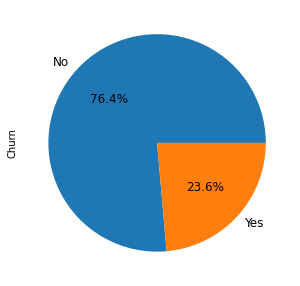

In [6]:
# Show the churn ratio for the whole dataset
# 0 is not churn, 1 is churn
# labels = ['no', 'yes']
(d['Churn'].value_counts()*100.0 /len(d)).plot.pie(autopct='%.1f%%', subplots=True, figsize =(5,5), fontsize = 12 )                                                                           


In [7]:
# Convert the predictor variable in a binary numeric variable

d['Churn'].replace(to_replace='Yes', value=1, inplace=True)
d['Churn'].replace(to_replace='No',  value=0, inplace=True)

d.head()

,gender,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,Male,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [8]:
# Reduce the dataset to customers that churned

churners = d['Churn'] == 1

churnset = d[churners]

churnset.head()

,gender,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2,Male,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
4,Female,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
5,Female,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
8,Female,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
13,Male,No,No,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [9]:
# Find which tenure length in months lead to the most churns
# Illustration needed
one_month_tenure = churnset['tenure'] == 1
one_month_tenure = churnset[one_month_tenure]

churnset['tenure'].mode()



0    1
dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f12ea4ec240>],
      dtype=object)

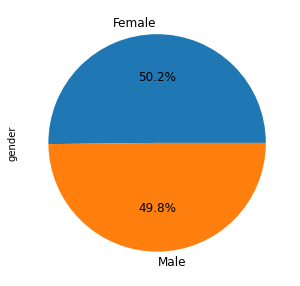

In [10]:
# Find the most dominant churned customer profile by gender
# labels = ['Male', 'Female']

(churnset['gender'].value_counts()*100.0 /len(d))\
.plot.pie(autopct='%.1f%%', subplots=True, figsize =(5,5), fontsize = 12)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f12ea4b8438>],
      dtype=object)

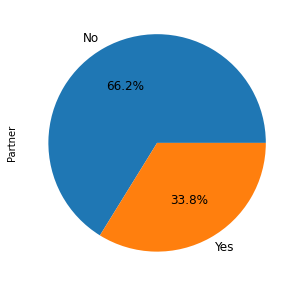

In [11]:
# Find the most dominant churned customer profile by partnered or not

(churnset['Partner'].value_counts()*100.0 /len(d))\
.plot.pie(autopct='%.1f%%', subplots=True, figsize =(5,5), fontsize = 12 )

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f12ea47f5c0>],
      dtype=object)

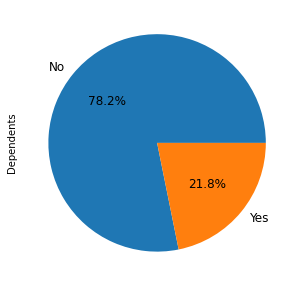

In [12]:
# Find the most dominant churned customer profile by whether they have dependents or not

(churnset['Dependents'].value_counts()*100.0 /len(d))\
.plot.pie(autopct='%.1f%%', subplots=True, figsize =(5,5), fontsize = 12 )                                                                           

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f12ea44e748>],
      dtype=object)

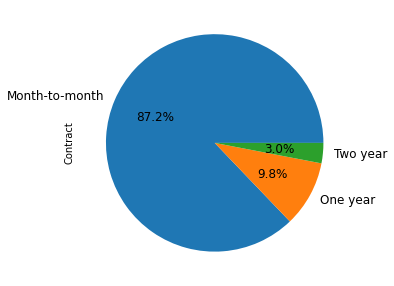

In [13]:
# Find the dominant contract type that customers churned on
(churnset['Contract'].value_counts()*100.0 /len(d))\
.plot.pie(autopct='%.1f%%', subplots=True, figsize =(5,5), fontsize = 12)

Text(0.5, 1.0, '# of Customers by Contract Type')

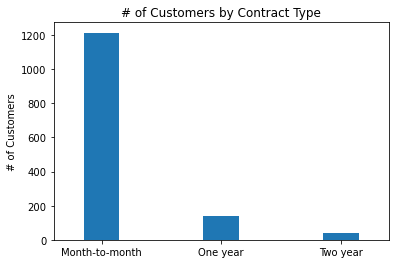

In [14]:
# Find the dominant contract that customers churned on

ax = churnset['Contract'].value_counts().plot(kind = 'bar',rot = 0, width = 0.3)
ax.set_ylabel('# of Customers')
ax.set_title('# of Customers by Contract Type')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f12ea390f60>],
      dtype=object)

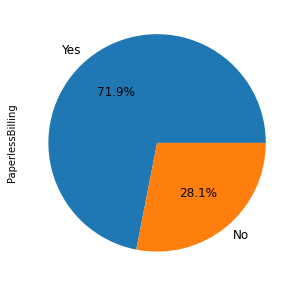

In [15]:
# Find the most dominant churned customer profile by paperless billing or not

(churnset['PaperlessBilling'].value_counts()*100.0 /len(d))\
.plot.pie(autopct='%.1f%%', subplots=True, figsize =(5,5), fontsize = 12 )                                                                           


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f12ea35b908>],
      dtype=object)

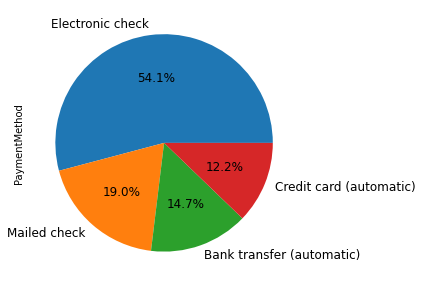

In [16]:
# Find the most dominant churned customer profile by payment method

(churnset['PaymentMethod'].value_counts()*100.0 /len(d))\
.plot.pie(autopct='%.1f%%', subplots=True, figsize =(5,5), fontsize = 12)

/srv/conda/envs/notebook/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/srv/conda/envs/notebook/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/srv/conda/envs/notebook/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/srv/conda/envs/notebook/lib/python

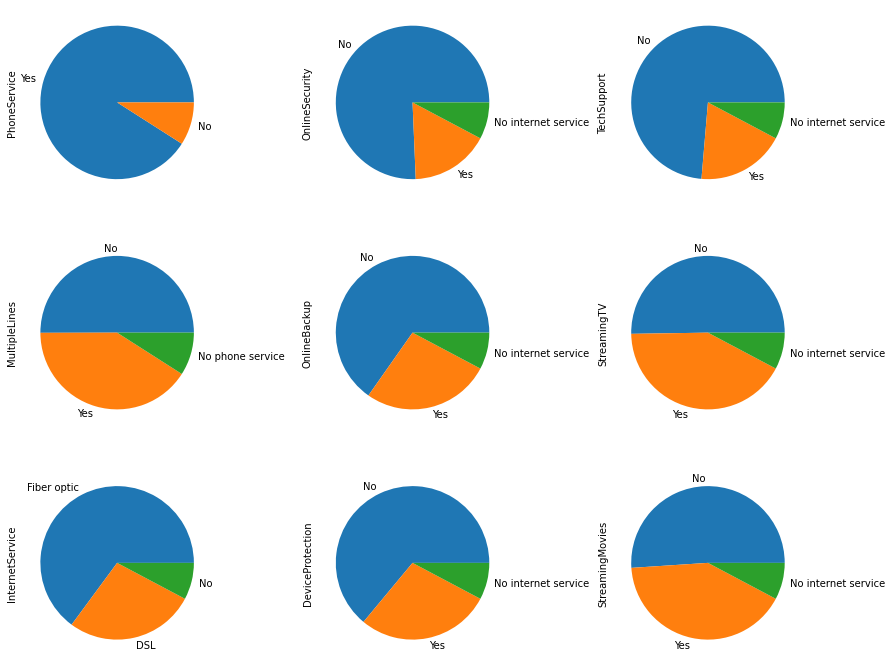

In [17]:
# What service types customers had when they churned

services = ['PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

fig, axes = plt.subplots(nrows = 3,ncols = 3, figsize = (15, 12))
for i, item in enumerate(services):
    if i < 3:
        ax = churnset[item].value_counts().plot(kind = 'pie', subplots=True, ax=axes[i,0],rot = 0)

    elif i >=3 and i < 6:
        ax = churnset[item].value_counts().plot(kind = 'pie', subplots=True, ax=axes[i-3,1],rot = 0)
        
    elif i < 9:
        ax = churnset[item].value_counts().plot(kind = 'pie', subplots=True, ax=axes[i-6,2],rot = 0)

In [18]:
churnset['MonthlyCharges'].mode()

0    45.3
1    70.0
2    74.9
3    94.4
dtype: float64

In [29]:
# What % of churns are the dominant profile?

dominant = churnset.loc[churnset['gender'] == 'Female']
x = dominant.loc[dominant['Partner'] == 'No']
x = x.loc[x['Dependents'] == 'No']
x = x.loc[x['Contract'] == 'Month-to-month']
x = x.loc[x['PaperlessBilling'] == 'Yes']
x = x.loc[x['PaymentMethod'] == 'Electronic check']
x = x.loc[x['tenure'] == 1]


x

,gender,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
534,Female,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,85.00,85,1
783,Female,No,No,1,Yes,No,DSL,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,52.20,52.2,1
1185,Female,No,No,1,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,60.15,60.15,1
1208,Female,No,No,1,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,80.25,80.25,1
1694,Female,No,No,1,No,No phone service,DSL,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,34.70,34.7,1
2069,Female,No,No,1,Yes,No,Fiber optic,Yes,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.60,95.6,1
2464,Female,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,77.15,77.15,1
2577,Female,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,94.60,94.6,1
2861,Female,No,No,1,Yes,No,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,81.95,81.95,1
2891,Female,No,No,1,Yes,No,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,79.70,79.7,1


In [26]:
# Reduce the dataset to customers that did not churned

nonchurners = d['Churn'] == 0

nonchurnset = d[nonchurners]

nonchurnset.head()

,gender,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
3,Male,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
6,Male,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,0
7,Female,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,0


In [28]:
# What % of non churns are the dominant profile?

dominant = nonchurnset.loc[nonchurnset['gender'] == 'Female']
y = dominant.loc[dominant['Partner'] == 'No']
y = y.loc[y['Dependents'] == 'No']
y = y.loc[y['Contract'] == 'Month-to-month']
y = y.loc[y['PaperlessBilling'] == 'Yes']
y = y.loc[y['PaymentMethod'] == 'Electronic check']
y = y.loc[y['tenure'] == 1]


y

,gender,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
685,Female,No,No,1,Yes,No,DSL,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,49.90,49.9,0
2152,Female,No,No,1,Yes,Yes,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,50.10,50.1,0
2238,Female,No,No,1,Yes,No,Fiber optic,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,95.85,95.85,0
2371,Female,No,No,1,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,25.70,25.7,0
2388,Female,No,No,1,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.45,55.45,0
3328,Female,No,No,1,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.25,70.25,0
5474,Female,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.60,84.6,0
5652,Female,No,No,1,Yes,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,48.60,48.6,0
6663,Female,No,No,1,Yes,No,DSL,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,54.65,54.65,0
